In [1]:
from preprocessing import preprocess_parquet_table
import pyarrow.parquet as parquet
from data_iter import DataIter
import mxnet as mx
preprocess_parquet_table('./data/collabTrain','./train_preprocessed',\
                         cols=parquet.read_table(input_path + '/collabTrain/date=2018-02-07').to_pandas().columns)

preprocess_parquet_table('./data/collabTest','./test_preprocessed',\
                         cols=parquet.read_table(input_path + '/collabTest').to_pandas().columns,\
                         params_path='./train_preprocessed')
remove_features =['instanceId_objectId','instanceId_userId','feedback']
data_names=[i[:-4] for i in os.listdir('./data_preprocessed') if i.endswith('.npy') and not  (i[:-4] in remove_features)]
label_names=['feedback']
print(len(data_names))
data_iter = DataIter('./data_preprocessed',100,data_names=data_names,label_names=label_names,shuffle=True)
train = data_iter.inx[1000000:]
val = data_iter.inx[:1000000]
for k,v in data_iter.data.items():
    np.save('val_preprocessed/%s.npy'%k,v[val])
    np.save('train_preprocessed/%s.npy'%k,v[train])

In [2]:
import numpy as np
import pickle
def make_like_feature(path):
    data = np.load(path+'/feedback.npy')
    params = pickle.load(open(path+'/feedback.pkl','rb'))
    inx = list(params['unames']).index('Liked')
    data = data[:,[inx]]
    pickle.dump({'type':'categorical','unames':['NonLiked','Liked']},open(path+'/liked.pkl','wb'))
    np.save(path+'/liked.npy',data.astype(np.uint8))
    
make_like_feature('./train_preprocessed')

In [3]:
from data_iter import SeqDataIter
import mxnet as mx

In [4]:
ctx=[mx.gpu(0),mx.gpu(1)]
num_epoch=100
exp_dir='exps'
load_epoch=0
name='seq2seq'
batch_size=512
seq_len = 8

In [5]:
import os
remove_features = ['instanceId_objectId','instanceId_userId','liked']
data_names=[i[:-4] for i in os.listdir('./train_preprocessed') if i.endswith('.npy') and not  (i[:-4] in remove_features)]
label_names=['liked']
print(len(data_names))

108


In [6]:
train_iter = SeqDataIter('./train_preprocessed',batch_size,data_names=data_names,label_names=label_names,shuffle=True,usampling=True,seq_len=seq_len)
val_iter = SeqDataIter('./val_preprocessed',batch_size,data_names=data_names,label_names=label_names,shuffle=False,max_len=batch_size*1000,seq_len=seq_len)
# test_iter = DataIter('./test_preprocessed',batch_size,data_names=data_names,label_names=[],shuffle=False)

In [7]:
from model import make_network,add_loss
sym = make_network(train_iter,seq_len)
sym = add_loss(sym)

In [8]:
mx.viz.print_summary(sym,dict(train_iter.provide_data))

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
userOwnerCounters_USER_PHOTO_ALBUM_COMMENT_CREATE(nu1                       0                                           
________________________________________________________________________________________________________________________
userOwnerCounters_USER_PHOTO_ALBUM_COMMENT_CREATE_em1x16                    0           userOwnerCounters_USER_PHOTO_ALB
________________________________________________________________________________________________________________________
reshape0(Reshape)                                   16                      0           userOwnerCounters_USER_PHOTO_ALB
________________________________________________________________________________________________________________________
split0(SliceChannel)            

In [ ]:
from train import train

model = train(sym,train_iter,val_iter,
      name=name,
      load_epoch=load_epoch,
      batch_size=batch_size,
      exp_dir=exp_dir)

Saving with prefix: exps/seq2seq/snapshots/seq2seq
exps/seq2seq/train.log


2019-03-04 20:44:46,837 Epoch[0] Batch [0-500]	Speed: 9460.71 samples/sec	accuracy=0.668756
2019-03-04 20:45:13,873 Epoch[0] Batch [500-1000]	Speed: 9469.12 samples/sec	accuracy=0.712199
2019-03-04 20:45:40,980 Epoch[0] Batch [1000-1500]	Speed: 9444.70 samples/sec	accuracy=0.722074
2019-03-04 20:46:08,081 Epoch[0] Batch [1500-2000]	Speed: 9446.82 samples/sec	accuracy=0.729109
2019-03-04 20:46:35,177 Epoch[0] Batch [2000-2500]	Speed: 9449.07 samples/sec	accuracy=0.734133
2019-03-04 20:47:02,330 Epoch[0] Batch [2500-3000]	Speed: 9428.39 samples/sec	accuracy=0.740465
2019-03-04 20:47:29,458 Epoch[0] Batch [3000-3500]	Speed: 9439.19 samples/sec	accuracy=0.743074
2019-03-04 20:47:56,577 Epoch[0] Batch [3500-4000]	Speed: 9440.31 samples/sec	accuracy=0.743332
2019-03-04 20:48:23,711 Epoch[0] Batch [4000-4500]	Speed: 9435.04 samples/sec	accuracy=0.740000
2019-03-04 20:48:50,736 Epoch[0] Batch [4500-5000]	Speed: 9473.34 samples/sec	accuracy=0.748703
2019-03-04 20:49:09,973 Epoch[0] Train-accura

2019-03-04 21:21:09,188 Epoch[6] Batch [4500-5000]	Speed: 9284.62 samples/sec	accuracy=0.801570
2019-03-04 21:21:28,782 Epoch[6] Train-accuracy=0.797281
2019-03-04 21:21:28,783 Epoch[6] Time cost=295.290
2019-03-04 21:21:29,067 Saved checkpoint to "exps/seq2seq/snapshots/seq2seq-0007.params"
2019-03-04 21:21:50,870 Epoch[6] Validation-accuracy=0.962354
2019-03-04 21:22:24,712 Epoch[7] Batch [0-500]	Speed: 9355.20 samples/sec	accuracy=0.820141
2019-03-04 21:22:52,247 Epoch[7] Batch [500-1000]	Speed: 9298.15 samples/sec	accuracy=0.813492
2019-03-04 21:23:19,784 Epoch[7] Batch [1000-1500]	Speed: 9297.24 samples/sec	accuracy=0.806742
2019-03-04 21:23:47,395 Epoch[7] Batch [1500-2000]	Speed: 9272.23 samples/sec	accuracy=0.812066
2019-03-04 21:24:15,054 Epoch[7] Batch [2000-2500]	Speed: 9255.74 samples/sec	accuracy=0.809047
2019-03-04 21:24:42,714 Epoch[7] Batch [2500-3000]	Speed: 9255.67 samples/sec	accuracy=0.808465
2019-03-04 21:25:10,339 Epoch[7] Batch [3000-3500]	Speed: 9267.25 samples/

2019-03-04 21:57:06,388 Epoch[13] Batch [2500-3000]	Speed: 9253.20 samples/sec	accuracy=0.830578
2019-03-04 21:57:34,038 Epoch[13] Batch [3000-3500]	Speed: 9260.08 samples/sec	accuracy=0.831453
2019-03-04 21:58:01,746 Epoch[13] Batch [3500-4000]	Speed: 9239.99 samples/sec	accuracy=0.828688
2019-03-04 21:58:29,376 Epoch[13] Batch [4000-4500]	Speed: 9265.87 samples/sec	accuracy=0.823691
2019-03-04 21:58:56,986 Epoch[13] Batch [4500-5000]	Speed: 9272.35 samples/sec	accuracy=0.830203
2019-03-04 21:59:16,669 Epoch[13] Train-accuracy=0.818979
2019-03-04 21:59:16,670 Epoch[13] Time cost=295.908
2019-03-04 21:59:16,980 Saved checkpoint to "exps/seq2seq/snapshots/seq2seq-0014.params"
2019-03-04 21:59:38,592 Epoch[13] Validation-accuracy=0.964035
2019-03-04 22:00:12,507 Epoch[14] Batch [0-500]	Speed: 9332.65 samples/sec	accuracy=0.843290
2019-03-04 22:00:40,026 Epoch[14] Batch [500-1000]	Speed: 9303.14 samples/sec	accuracy=0.840398
2019-03-04 22:01:07,576 Epoch[14] Batch [1000-1500]	Speed: 9293.

2019-03-04 22:33:05,289 Epoch[20] Batch [500-1000]	Speed: 9272.08 samples/sec	accuracy=0.848578
2019-03-04 22:33:32,943 Epoch[20] Batch [1000-1500]	Speed: 9257.77 samples/sec	accuracy=0.842934
2019-03-04 22:34:00,654 Epoch[20] Batch [1500-2000]	Speed: 9238.29 samples/sec	accuracy=0.841805
2019-03-04 22:34:28,353 Epoch[20] Batch [2000-2500]	Speed: 9242.56 samples/sec	accuracy=0.845879
2019-03-04 22:34:55,938 Epoch[20] Batch [2500-3000]	Speed: 9281.57 samples/sec	accuracy=0.846160
2019-03-04 22:35:23,506 Epoch[20] Batch [3000-3500]	Speed: 9286.75 samples/sec	accuracy=0.845852
2019-03-04 22:35:51,183 Epoch[20] Batch [3500-4000]	Speed: 9249.66 samples/sec	accuracy=0.840445
2019-03-04 22:36:18,858 Epoch[20] Batch [4000-4500]	Speed: 9250.63 samples/sec	accuracy=0.839875
2019-03-04 22:36:46,505 Epoch[20] Batch [4500-5000]	Speed: 9260.73 samples/sec	accuracy=0.845977
2019-03-04 22:37:06,260 Epoch[20] Train-accuracy=0.836966
2019-03-04 22:37:06,261 Epoch[20] Time cost=295.986
2019-03-04 22:37:0

2019-03-04 23:09:32,500 Epoch[26] Train-accuracy=0.846721
2019-03-04 23:09:32,501 Epoch[26] Time cost=295.769
2019-03-04 23:09:32,821 Saved checkpoint to "exps/seq2seq/snapshots/seq2seq-0027.params"
2019-03-04 23:09:55,009 Epoch[26] Validation-accuracy=0.968541
2019-03-04 23:10:28,787 Epoch[27] Batch [0-500]	Speed: 9348.04 samples/sec	accuracy=0.866720
2019-03-04 23:10:56,403 Epoch[27] Batch [500-1000]	Speed: 9270.57 samples/sec	accuracy=0.863328
2019-03-04 23:11:24,100 Epoch[27] Batch [1000-1500]	Speed: 9243.08 samples/sec	accuracy=0.863148
2019-03-04 23:11:51,768 Epoch[27] Batch [1500-2000]	Speed: 9253.27 samples/sec	accuracy=0.860262
2019-03-04 23:12:19,413 Epoch[27] Batch [2000-2500]	Speed: 9260.92 samples/sec	accuracy=0.860867
2019-03-04 23:12:47,027 Epoch[27] Batch [2500-3000]	Speed: 9271.31 samples/sec	accuracy=0.862086
2019-03-04 23:13:14,550 Epoch[27] Batch [3000-3500]	Speed: 9303.45 samples/sec	accuracy=0.860570
2019-03-04 23:13:42,137 Epoch[27] Batch [3500-4000]	Speed: 9280.

2019-03-04 23:45:38,116 Epoch[33] Batch [3000-3500]	Speed: 9260.90 samples/sec	accuracy=0.865012
2019-03-04 23:46:05,773 Epoch[33] Batch [3500-4000]	Speed: 9258.06 samples/sec	accuracy=0.862688
2019-03-04 23:46:33,307 Epoch[33] Batch [4000-4500]	Speed: 9300.15 samples/sec	accuracy=0.858840
2019-03-04 23:47:00,897 Epoch[33] Batch [4500-5000]	Speed: 9279.05 samples/sec	accuracy=0.863637
2019-03-04 23:47:20,490 Epoch[33] Train-accuracy=0.855953
2019-03-04 23:47:20,491 Epoch[33] Time cost=295.341
2019-03-04 23:47:20,781 Saved checkpoint to "exps/seq2seq/snapshots/seq2seq-0034.params"
2019-03-04 23:47:42,200 Epoch[33] Validation-accuracy=0.967984
2019-03-04 23:48:16,150 Epoch[34] Batch [0-500]	Speed: 9326.11 samples/sec	accuracy=0.872864
2019-03-04 23:48:43,738 Epoch[34] Batch [500-1000]	Speed: 9279.61 samples/sec	accuracy=0.871516
2019-03-04 23:49:11,380 Epoch[34] Batch [1000-1500]	Speed: 9264.51 samples/sec	accuracy=0.868664
2019-03-04 23:49:39,001 Epoch[34] Batch [1500-2000]	Speed: 9272.

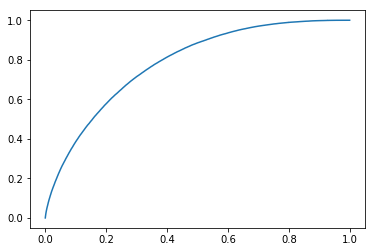

In [35]:
from test import predict,score,make_submission
%matplotlib inline
score(val_iter,7,name)
prediction = predict(test_iter,7,name)    
make_submission(prediction,name)